In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
data = pd.read_csv("FRB_H15.csv",header = 0,skiprows = 5).replace('ND',np.nan)
data.drop(['RIFLGFCM01_N.B','RIFLGFCM03_N.B','RIFLGFCM06_N.B','RIFLGFCY02_N.B','RIFLGFCY07_N.B','RIFLGFCY20_N.B','RIFLGFCY30_N.B'],axis = 1,inplace = True)
data['Time Period'] = pd.to_datetime(data['Time Period'])
dates = pd.DataFrame(pd.date_range(start = '1962-01-02',end = '2017-10-5'))
dates.columns = ['Time Period']
data = dates.merge(data,how = 'left',on = 'Time Period')

data['IS_WEEKEND'] = 1
data['Day of week'] = data['Time Period'].dt.dayofweek
weekend = data['IS_WEEKEND'].copy()
weekend[(data['Day of week'] != 5) & (data['Day of week'] != 6)] = 0
data['IS_WEEKEND'] = weekend

#impute missing values
f1 = data['RIFLGFCY01_N.B'].copy()
f2 = data['RIFLGFCY03_N.B'].copy()
f3 = data['RIFLGFCY05_N.B'].copy()
f4 = data['RIFLGFCY10_N.B'].copy()
for i in range(len(data)):
    if data['IS_WEEKEND'].iloc[i] == 1:
        f1[i] = f1[i-1]
        f2[i] = f2[i-1]
        f3[i] = f3[i-1]
        f4[i] = f4[i-1]
        
for i in range(len(f1)):
    if pd.isnull(f1[i]):
        j = i - 1
        while pd.isnull(f1[j]):
            j = j - 1
        f1[i] = f1[j]

for i in range(len(f2)):
    if pd.isnull(f2[i]):
        j = i - 1
        while pd.isnull(f2[j]):
            j = j - 1
        f2[i] = f2[j]

for i in range(len(f3)):
    if pd.isnull(f3[i]):
        j = i - 1
        while pd.isnull(f3[j]):
            j = j - 1
        f3[i] = f3[j]

for i in range(len(f4)):
    if pd.isnull(f4[i]):
        j = i - 1
        while pd.isnull(f4[j]):
            j = j - 1
        f4[i] = f4[j]
        
data['RIFLGFCY01_N.B'] = f1
data['RIFLGFCY03_N.B'] = f2
data['RIFLGFCY05_N.B'] = f3
data['RIFLGFCY10_N.B'] = f4


data['RIFLGFCY01_N.B'] = data['RIFLGFCY01_N.B'].astype(float)
data['RIFLGFCY03_N.B'] = data['RIFLGFCY03_N.B'].astype(float)
data['RIFLGFCY05_N.B'] = data['RIFLGFCY05_N.B'].astype(float)
data['RIFLGFCY10_N.B'] = data['RIFLGFCY10_N.B'].astype(float)

#Difference the data from the rolling mean to make it stationary
#Check for stationarity using dickey fuller test


from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

In [3]:
#Select data after 2000
data_after_2000 = data[data['Time Period']>='2000-01-01'].set_index('Time Period')
#remove weekend
data_after_2000 = data_after_2000[data_after_2000['IS_WEEKEND']==0]

#difference data from rolling mean
data_after_2000_diff = (data_after_2000 - pd.rolling_mean((data_after_2000),100))



#test on 2017 (assume one day's data in 2017 is missing, try to fill it using MCMC with available data after 2000)
train = data_after_2000_diff[data_after_2000_diff.index<='2016-12-31'].iloc[100:,]
test = data_after_2000_diff[data_after_2000_diff.index>='2017-01-01']

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=100).mean()
  import sys


In [4]:
#Try one year maturity
train_one_year = train['RIFLGFCY01_N.B']
test_one_year = test['RIFLGFCY01_N.B']


D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:73: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:74: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).std()


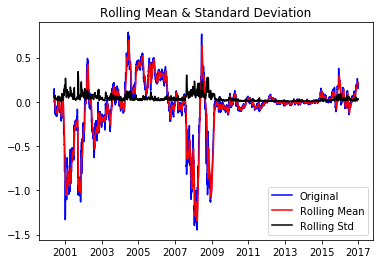

Results of Dickey-Fuller Test:
Test Statistic                   -4.742892
p-value                           0.000070
#Lags Used                       21.000000
Number of Observations Used    4313.000000
Critical Value (1%)              -3.431867
Critical Value (5%)              -2.862210
Critical Value (10%)             -2.567127
dtype: float64


In [5]:
test_stationarity(train_one_year)

Gibbs sampling for filling missing value

In [32]:
#Define starting values 
def get_starting_values(ar_order, data, missing_id):
    
    '''
    Let staring value of missing value xh be the previous day value
    Fill the missing value by the previous day value to fit an AR(p) model, and use the coefficients of this model
    as the starting values of φ and σ^2
    '''
    data_temp = np.array(data)
    xh_start = data_temp[(missing_id-1)]
    
    data_temp[missing_id] = xh_start
    
    model = ARIMA(data_temp, order=(ar_order,0,0))
    
    model_fit = model.fit(trend='nc') #don't include constant term when fit
    
    phi_start = list(model_fit.arparams)
    sigma_start = model_fit.sigma2
    
    
    return (xh_start,phi_start,sigma_start)
    
    
    

In [100]:
def gibbs_sampling(n_iter, data, missing_id, ar_order):
    data_temp = np.array(data)
    data_temp[missing_id] = np.nan
    
    phi = []
    sigma = []
    xh = []
    
    #Define hyperparameters
    phi_0 = 0
    sigma_0_phi = 0.25
    miu_0 = 0
    sigma_0_xh = np.nanvar(data_temp)
    v = 10
    lambda_ = 0.05
    
    #Get starting values
    xh_start, phi_start, sigma_start = get_starting_values(ar_order, data, missing_id)
    
    
    phi_temp = phi_start[0] #AR(1)
    data_temp[missing_id] = xh_start
    sigma_temp = sigma_start
    
    for t in range(n_iter):
        #update phi_temp
        sigma_phi_temp = ((np.sum(np.square(data_temp[:-1]))/sigma_temp)+(sigma_0_phi)**-1)**-1
        miu_phi_temp = ((sum(data_temp[:-1]*data_temp[1:])/sigma_temp) + ((sigma_0_phi)**-1)*phi_0 )* sigma_phi_temp

        phi_temp = np.random.normal(miu_phi_temp, sigma_phi_temp)
        phi.append(phi_temp)
        
        #update sigma_temp
        sigma_temp = (v*lambda_ + np.sum(np.square(data_temp[1:]-phi_temp*data_temp[:-1])))/np.random.chisquare(v+len(data_temp)-1)

        sigma.append(sigma_temp)
        
        #update xh temp and data
        miu_xh_temp = (sigma_temp*miu_0+sigma_0_xh*phi_temp*(data_temp[missing_id-1]+data_temp[missing_id+1]))/(sigma_temp+sigma_0_xh*(1+phi_temp**2))
        sigma_xh_temp = (sigma_temp*sigma_0_xh)/(sigma_temp+sigma_0_xh*(1+phi_temp**2))
        
        xh_temp = np.random.normal(miu_xh_temp, sigma_xh_temp)

        data_temp[missing_id] = xh_temp
        xh.append(xh_temp)
        
    return phi,sigma,xh

In [101]:

predictions = []
phis = []
sigmas = []
train_temp = list(train_one_year)+list(test_one_year)
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test_one_year)-1):
    phi,sigma,prediction = gibbs_sampling(2100,train_temp,len(train_one_year)+t,1)
    yhat = np.mean(np.array(prediction)[100:]) #discard first 100 iterations
    phi = np.mean(np.array(phi)[100:])
    sigma = np.mean(np.array(sigma)[100:])
    
    predictions.append(yhat)
    phis.append(phi)
    sigmas.append(sigma)
    print('predicted= ',yhat, 'expected= ',train_temp[len(train_one_year)+t])

error = mean_squared_error(list(test_one_year)[:-1], predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: ' , error)

#predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=  0.166683423094 expected=  0.1482
predicted=  0.153900348716 expected=  0.185
predicted=  0.151052454845 expected=  0.1621
predicted=  0.148342632534 expected=  0.1196
predicted=  0.111207059723 expected=  0.137
predicted=  0.118619640207 expected=  0.1046
predicted=  0.101438324664 expected=  0.1022
predicted=  0.0942350198416 expected=  0.0999
predicted=  0.0970538028537 expected=  0.0878
predicted=  0.0900525852739 expected=  0.0958
predicted=  0.0831483410459 expected=  0.0938
predicted=  0.0910538412843 expected=  0.0719
predicted=  0.0840032194234 expected=  0.0898
predicted=  0.0868300600666 expected=  0.0975
predicted=  0.074776083309 expected=  0.0852
predicted=  0.0773543778784 expected=  0.0532
predicted=  0.0651335906845 expected=  0.0707
predicted=  0.0726227135317 expected=  0.0782
predicted=  0.075139917733 expected=  0.0757
predicted=  0.0677531189863 expected=  0.0733
predicted=  0.0804072358433 expected=  0.0609
pr

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=  0.17194705277 expected=  0.1683
predicted=  0.178285991454 expected=  0.1748
predicted=  0.184569530409 expected=  0.1912
predicted=  0.185784852369 expected=  0.1974
predicted=  0.201708280598 expected=  0.1834
predicted=  0.182957414332 expected=  0.2093
predicted=  0.198837741149 expected=  0.1855
predicted=  0.185083682397 expected=  0.1916
predicted=  0.191027636507 expected=  0.1877
predicted=  0.187241817268 expected=  0.1936
predicted=  0.188214185742 expected=  0.1898
predicted=  0.184451595582 expected=  0.1859
predicted=  0.175645525489 expected=  0.1821
predicted=  0.166715782395 expected=  0.1682
predicted=  0.167687840395 expected=  0.1541
predicted=  0.153624827103 expected=  0.1699
predicted=  0.169262015172 expected=  0.1557
predicted=  0.165037754004 expected=  0.1714
predicted=  0.170732973504 expected=  0.1771
predicted=  0.171622585756 expected=  0.1729
predicted=  0.167662286646 expected=  0.1689
predicted=  0.158628506759 expected=  0.1651
predicted= 

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=  0.11376465494 expected=  0.0797
predicted=  0.0912314005816 expected=  0.1166
predicted=  0.108330162417 expected=  0.1042
predicted=  0.105821707995 expected=  0.1018
predicted=  0.108489549957 expected=  0.1092
predicted=  0.106228697042 expected=  0.117
predicted=  0.104282298863 expected=  0.105
predicted=  0.0973385824719 expected=  0.0932
predicted=  0.0956108295551 expected=  0.0913
predicted=  0.0889376631818 expected=  0.0996
predicted=  0.101894639142 expected=  0.088
predicted=  0.0851468397868 expected=  0.1058
predicted=  0.0978038780636 expected=  0.0837
predicted=  0.0808273046766 expected=  0.0914
predicted=  0.0933960982393 expected=  0.0793
predicted=  0.0713939367248 expected=  0.0969
predicted=  0.0839613915429 expected=  0.0647
predicted=  0.0619990375312 expected=  0.0724
predicted=  0.074630272309 expected=  0.0603
predicted=  0.0675655584359 expected=  0.078
predicted=  0.0803514651046 expected=  0.076
predicted=  0.0783145577513 expected=  0.084
pre

D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=  0.0864347589323 expected=  0.0822
predicted=  0.0892699322787 expected=  0.0999
predicted=  0.101888924689 expected=  0.0978
predicted=  0.104682274074 expected=  0.1055
predicted=  0.102570150708 expected=  0.1133
predicted=  0.100477331451 expected=  0.1013
predicted=  0.0936567750206 expected=  0.0893
predicted=  0.091804885887 expected=  0.0875
predicted=  0.0998490151168 expected=  0.0958
predicted=  0.0930947197975 expected=  0.1138
predicted=  0.10110039651 expected=  0.092
predicted=  0.0893186867375 expected=  0.09
predicted=  0.0921939519042 expected=  0.088
predicted=  0.0949471919648 expected=  0.0959
predicted=  0.107490586696 expected=  0.1034


Printing Mean Squared Error of Predictions...
Test MSE:  0.000162449026825


In [102]:
#Add back previous 100 days rolling means to get actual value of predictions. Then compute RMSE

pred_actual = predictions+pd.rolling_mean((data_after_2000),100).loc[test_one_year.index[0]:test_one_year.index[-2]]['RIFLGFCY01_N.B']
#test_one_year[:-1]+pd.rolling_mean((data_after_2000),100).loc[test_one_year.index[0]:test_one_year.index[-2]]['RIFLGFCY01_N.B']
test_one_year_actual = data_after_2000.loc[test_one_year.index[0]:test_one_year.index[-2]]['RIFLGFCY01_N.B']
print('RMSE: ', np.sqrt(mean_squared_error(test_one_year_actual, pred_actual)))
print('R sq: ',r2_score(test_one_year_actual,pred_actual))

RMSE:  0.0127455492948
R sq:  0.993953804648


D:\anaconda_py3\python3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=100).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE:  0.0127455492948
R sq:  0.993953804648


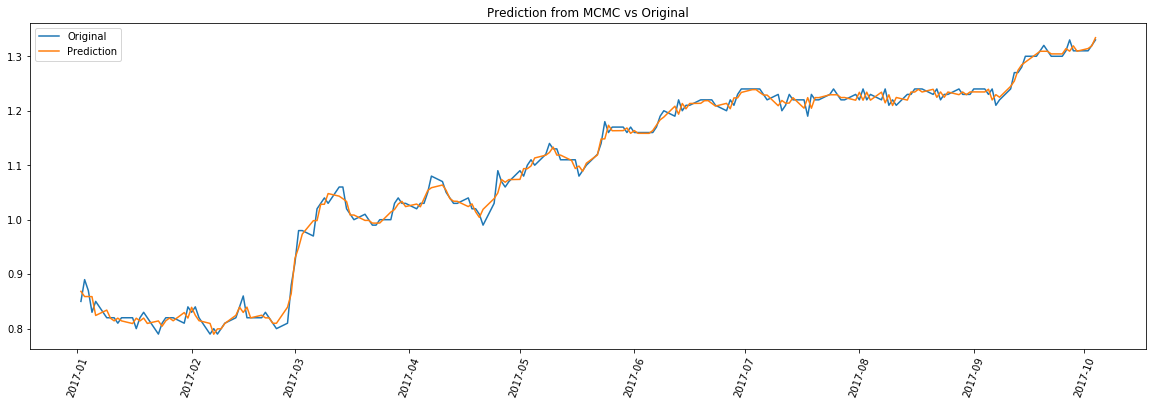

In [154]:
orig = plt.plot(test_one_year_actual,label='Original')
pred = plt.plot(pred_actual,label='Prediction')
plt.xticks(rotation=70)
plt.legend(loc='best')
plt.title('Prediction from MCMC vs Original')
print('RMSE: ', np.sqrt(mean_squared_error(test_one_year_actual, pred_actual)))
print('R sq: ',r2_score(test_one_year_actual,pred_actual))
plt.show()
plt.rcParams["figure.figsize"] = (20,6)


phi_gibbs = plt.plot(np.array(phis))
phi_mle = plt.plot(0.99246338*np.ones(len(phis)))
plt.ylim(ymin = 0.992,ymax=0.994)
plt.show()

In [127]:
model = ARIMA(train_temp, order=(1,0,0))
model_fit = model.fit(trend='nc')
print('Maximum Likelihood Estimate of φ: ',model_fit.arparams[0])

Maximum Likelihood Estimate of φ:  0.992463381725


In [128]:
print('Gibbs Sampling Estimate of φ： ', np.array(phis).mean())

Gibbs Sampling Estimate of φ：  0.992648548843


In [130]:
print('Maximum Likelihood Estimate of σ^2: ',model_fit.sigma2)

Maximum Likelihood Estimate of σ^2:  0.00152891783311


In [131]:
print('Gibbs Sampling Estimate of σ^2： ', np.array(sigmas).mean())

Gibbs Sampling Estimate of σ^2：  0.00163664750535
